Download complete.
Extracting dataset...
Extraction complete.
Dataset ready for use.
Extracting features...

 Training classifier with Hann window...
 Classification Accuracy (Hann Window): 0.40


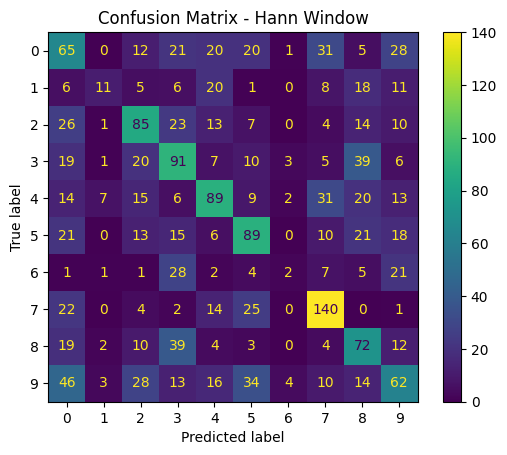


 Training classifier with Hamming window...
 Classification Accuracy (Hamming Window): 0.41


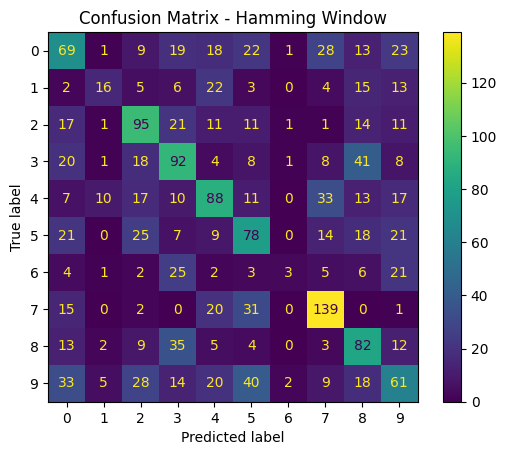


 Training classifier with Rectangular window...
 Classification Accuracy (Rectangular Window): 0.43


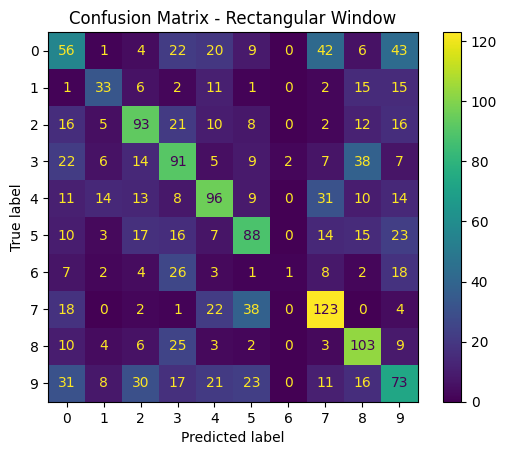

File not found: UrbanSound8K/UrbanSound8K/audio/fold1/100032-3-0-0.wav


In [2]:
import os
import requests
import tarfile
import numpy as np
import pandas as pd
import librosa
import librosa.display
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def download_and_extract_dataset():
    dataset_url = "https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz?download=1"
    download_path = "UrbanSound8K.tar.gz"
    extract_path = "UrbanSound8K"

    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    print("Downloading UrbanSound8k dataset...")
    response = requests.get(dataset_url, stream=True)
    if response.status_code == 200:
        with open(download_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print("Download complete.")
    else:
        print(f"Failed to download dataset. HTTP Status Code: {response.status_code}")
        exit()

    print("Extracting dataset...")
    with tarfile.open(download_path, 'r:gz') as tar_ref:
        tar_ref.extractall(extract_path)
    print("Extraction complete.")

    os.remove(download_path)
    print("Dataset ready for use.")

download_and_extract_dataset()

# Dataset paths
csv_path = "UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
base_path = "UrbanSound8K/UrbanSound8K/audio/"

# Load metadata
metadata = pd.read_csv(csv_path)

# STFT parameters
n_fft = 1024
hop_length = 512

# Define window functions
window_types = {
    "Hann": np.hanning(n_fft),
    "Hamming": np.hamming(n_fft),
    "Rectangular": np.ones(n_fft),
}

# Function to plot and compare spectrograms
def plot_spectrograms(file_path, sr, y):
    plt.figure(figsize=(15, 5))
    for i, (win_name, window) in enumerate(window_types.items(), 1):
        _, _, Zxx = stft(y, fs=sr, window=window, nperseg=n_fft, noverlap=hop_length)
        spectrogram = np.abs(Zxx)
        plt.subplot(1, 3, i)
        librosa.display.specshow(
            librosa.amplitude_to_db(spectrogram, ref=np.max),
            sr=sr,
            hop_length=hop_length,
            x_axis="time",
            y_axis="log",
            cmap="inferno",
        )
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Spectrogram - {win_name} Window")
    plt.tight_layout()
    plt.show()

# Function to extract MFCC features from a spectrogram
def compute_audio_features(audio_file, window_type):
    # Load the audio file
    signal, sample_rate = librosa.load(audio_file, sr=None)

    # Apply the specified window function
    window_function = window_types[window_type]
    frequencies, times, stft_matrix = stft(signal, fs=sample_rate, window=window_function, nperseg=1024, noverlap=512)
    magnitude_spectrum = np.abs(stft_matrix)

    # Convert to MFCC features
    mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(magnitude_spectrum), sr=sample_rate, n_mfcc=13)

    # Summarize features by averaging across time frames
    summarized_features = np.mean(mfcc_features, axis=1)
    return summarized_features

# Initialize storage for features and labels
features = {"Hann": [], "Hamming": [], "Rectangular": []}
labels = []

# Process dataset and extract features
print("Extracting features...")
for index, row in metadata.iterrows():
    file_path = os.path.join(base_path, f"fold{row['fold']}", row["slice_file_name"])
    try:
        for window_name in window_types.keys():
            mfcc_features = compute_audio_features(file_path, window_name)
            features[window_name].append(mfcc_features)
        labels.append(row["classID"])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Train and evaluate classifiers for each window type
for window_name, feature_list in features.items():
    print(f"\n Training classifier with {window_name} window...")
    # Convert to numpy arrays
    X = np.array(feature_list)
    y = np.array(labels)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train SVM classifier
    svm_model = SVC(kernel="linear")
    svm_model.fit(X_train, y_train)
    # Evaluate performance
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f" Classification Accuracy ({window_name} Window): {accuracy:.2f}")
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test)
    plt.title(f"Confusion Matrix - {window_name} Window")
    plt.show()




 Visualizing spectrograms for an example audio file...


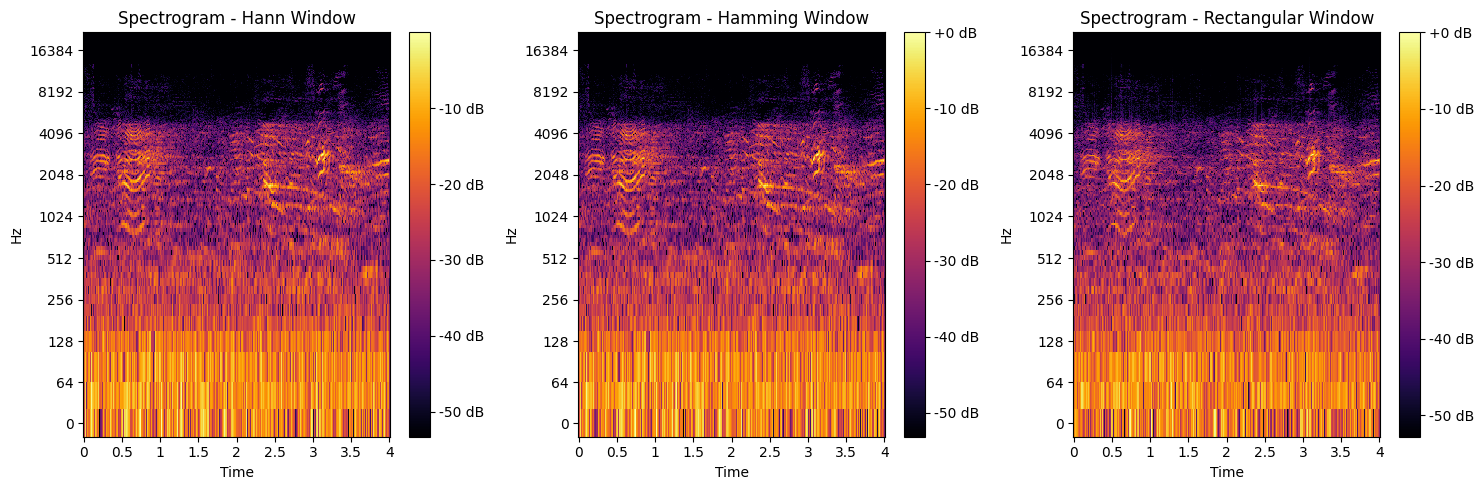

In [3]:
# Visualize spectrograms for an example audio file
example_file = os.path.join(base_path, "fold5", metadata.iloc[1]["slice_file_name"])
if os.path.exists(example_file):
    print("\n Visualizing spectrograms for an example audio file...")
    y, sr = librosa.load(example_file, sr=None)
    plot_spectrograms(example_file, sr, y)
else:
    print(f"File not found: {example_file}")